In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, TimeDistributed, Dropout
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, LSTM,Dropout,Conv2D,TimeDistributed
from tensorflow.keras.models import Sequential

d:\pYthon_Directory\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\pYthon_Directory\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# Access a variable (replace 'variable_name' with the actual name)
data = sio.loadmat('D:/lab_work_25/AUG/ppg to ecg/main_dataset_sub2.mat')
ppg = data['ppg_norm']
ecg = data['ecg_norm']
print(ppg.shape)
print(ecg.shape)

print(ppg.shape)
print(ecg.shape)

timepoints = 300
total_points = ppg.shape[1]
num_segments = total_points // timepoints  # full segments only

# Trim to multiple of 300
data_ppg = ppg[:, :num_segments * timepoints]

# Reshape: (samples, timepoints, 1)
ppg_segments = data_ppg.reshape(num_segments, timepoints, 1)

# Trim to multiple of 300
ecg_segments = ecg[:, :num_segments * timepoints]

# Reshape: (samples, timepoints, 1)
ecg_segments = ecg_segments.reshape(num_segments, timepoints, 1)

print("Original shape:", ppg.shape)
print("Trimmed shape:", data_ppg.shape)
print("Final shape:", ppg_segments.shape)
print("ECG segments shape:", ecg_segments.shape)

(1, 60001)
(1, 60001)
(1, 60001)
(1, 60001)
Original shape: (1, 60001)
Trimmed shape: (1, 60000)
Final shape: (200, 300, 1)
ECG segments shape: (200, 300, 1)


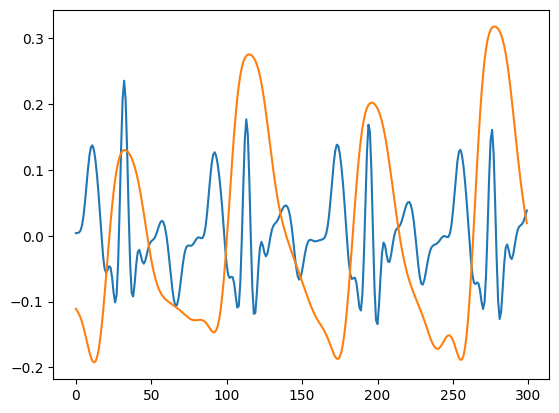

In [3]:
plt.plot(ecg_segments[15])
plt.plot(ppg_segments[15])

In [4]:
import tensorflow as tf
import numpy as np

# =====================================
# Utilities
# =====================================

def build_ring_adjacency(units: int, neighbors: int = 1, periodic: bool = True) -> tf.Tensor:
    adj = np.zeros((units, units), dtype=np.float32)
    for i in range(units):
        for d in range(1, neighbors + 1):
            if periodic:
                j1 = (i - d) % units
                j2 = (i + d) % units
                adj[i, j1] = 1.0
                adj[i, j2] = 1.0
            else:
                j1 = i - d
                j2 = i + d
                if 0 <= j1 < units:
                    adj[i, j1] = 1.0
                if 0 <= j2 < units:
                    adj[i, j2] = 1.0
    np.fill_diagonal(adj, 0.0)
    return tf.convert_to_tensor(adj, dtype=tf.float32)


def zero_diag(x: tf.Tensor) -> tf.Tensor:
    n = tf.shape(x)[0]
    return x * (1.0 - tf.eye(n, dtype=x.dtype))


# =====================================
# Kuramoto loop: local coupling + Hebbian
# =====================================

@tf.function
def kuramoto_loop_local_hebb(
    X_r: tf.Tensor,
    X_i: tf.Tensor,
    omegas: tf.Tensor,
    num_steps: int,
    K: tf.Variable,
    adjacency: tf.Tensor,
    *,
    dt: float = 1.0/125.0,
    input_scaler: float = 3.0,
    eta: float = 0.001,
    decay: float = 0.001,
    k_clip: float = 1.0,
    wrap_phase: bool = True,
    normalize_rows: bool = False,
    symmetric_K: bool = True,
) -> tuple[tf.Tensor, tf.Variable]:

    batch = tf.shape(X_r)[0]
    units = tf.shape(X_r)[-1]

    phi_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    phis = tf.zeros((batch, units), dtype=tf.float32)  # initial phase = 0

    if normalize_rows:
        deg = tf.reduce_sum(adjacency, axis=1, keepdims=True)
        deg = tf.maximum(deg, 1.0)

    two_pi = tf.constant(2.0 * np.pi, dtype=tf.float32)
    pi = tf.constant(np.pi, dtype=tf.float32)

    for t in tf.range(num_steps):
        input_r = input_scaler * X_r[:, t, :] * tf.math.cos(phis)
        input_i = input_scaler * X_i[:, t, :] * tf.math.sin(phis)

        delta = tf.expand_dims(phis, 1) - tf.expand_dims(phis, 2)
        sin_term = -tf.math.sin(delta)  # (batch, i, j)

        K_eff = adjacency * K
        if normalize_rows:
            K_eff = K_eff / deg
        coup = tf.einsum('ij,bij->bi', K_eff, sin_term)

        dphi = (omegas + input_r - input_i + coup) * dt
        phis = phis + dphi

        if wrap_phase:
            phis = ((phis + pi) % two_pi) - pi

        hebb = tf.reduce_mean(tf.math.cos(delta), axis=0)
        dK = eta * (adjacency * hebb) - decay * K
        K.assign_add(dK)

        if symmetric_K:
            K.assign(0.5 * (K + tf.transpose(K)))
        K.assign(zero_diag(K))
        if k_clip is not None:
            K.assign(tf.clip_by_value(K, -k_clip, k_clip))

        phi_arr = phi_arr.write(phi_arr.size(), phis)

    phis = tf.transpose(phi_arr.stack(), [1, 0, 2])
    return phis, K


# =====================================
# Kuramoto Layer with L2 regularized K
# =====================================

class KuramotoLocal(tf.keras.layers.Layer):
    def __init__(self,
                 units: int,
                 num_steps: int,
                 *,
                 min_omega: float = 0.1,
                 max_omega: float = 40.1,
                 train_omegas: bool = True,
                 neighbors: int = 2,
                 periodic: bool = True,
                 eta: float = 0.001,
                 decay: float = 0.001,
                 k_clip: float = 1.0,
                 normalize_rows: bool = False,
                 symmetric_K: bool = True,
                 dt: float = 1.0/125.0,
                 input_scaler: float = 5.0,
                 wrap_phase: bool = True,
                 reg_coeff: float = 1e-4,  # <--- NEW: L2 regularization strength
                 name: str = None,
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.units = units
        self.num_steps = num_steps
        self.min_omega = min_omega
        self.max_omega = max_omega
        self.train_omegas = train_omegas
        self.neighbors = neighbors
        self.periodic = periodic
        self.eta = eta
        self.decay = decay
        self.k_clip = k_clip
        self.normalize_rows = normalize_rows
        self.symmetric_K = symmetric_K
        self.dt = dt
        self.input_scaler = input_scaler
        self.wrap_phase = wrap_phase
        self.reg_coeff = reg_coeff

        # Intrinsic frequencies parameter
        omega_init = tf.random.uniform((1, units), -1.0, 1.0)
        self.omegas = tf.Variable(omega_init, trainable=train_omegas, name="omegas")

        # Coupling matrix with L2 regularization
        self.K = self.add_weight(
            shape=(units, units),
            initializer=tf.keras.initializers.RandomUniform(-0.05, 0.05),
            trainable=False,  # Hebbian update only
            regularizer=tf.keras.regularizers.L2(self.reg_coeff),
            name="K"
        )

        self.adjacency = build_ring_adjacency(units, neighbors, periodic)

    def call(self, X_r: tf.Tensor, X_i: tf.Tensor):
        omega_range = self.max_omega - self.min_omega
        omega_inp = tf.sigmoid(0.5 * self.omegas) * omega_range + self.min_omega

        phis, _ = kuramoto_loop_local_hebb(
            X_r, X_i, omega_inp, self.num_steps,
            self.K, self.adjacency,
            dt=self.dt,
            input_scaler=self.input_scaler,
            eta=self.eta,
            decay=self.decay,
            k_clip=self.k_clip,
            wrap_phase=self.wrap_phase,
            normalize_rows=self.normalize_rows,
            symmetric_K=self.symmetric_K,
        )

        z_real = tf.math.cos(phis)
        z_imag = tf.math.sin(phis)
        return z_real, z_imag


# =====================================
# Example Model
# =====================================

class Model(tf.keras.Model):
    def __init__(self, units1, units2, units3, units4, units6, units5, **kwargs):
        super().__init__(**kwargs)
        self.d1_r = tf.keras.layers.Dense(units1, activation='relu')
        self.d1_i = tf.keras.layers.Dense(units1, activation='relu')
        self.proj_r = tf.keras.layers.Dense(units2, activation=None)
        self.proj_i = tf.keras.layers.Dense(units2, activation=None)

        self.osc1 = KuramotoLocal(
            units=units2,
            num_steps=300,
            min_omega=0.1,
            max_omega=22.1,
            train_omegas=True,
            neighbors=2,
            periodic=True,
            eta=0.001,
            decay=0.001,
            k_clip=1.0,
            normalize_rows=False,
            symmetric_K=True,
            dt=1.0/125.0,
            input_scaler=2.0,
            wrap_phase=True,
            reg_coeff=1e-4,   # <--- L2 regularization coeff
        )

        self.d_r = tf.keras.layers.Dense(units3, activation='tanh')
        self.d_i = tf.keras.layers.Dense(units3, activation='tanh')
        self.dense = tf.keras.layers.Dense(units4, activation='tanh')
        self.dropout1 = tf.keras.layers.Dropout(0.3)   # NEW
        self.dense1 = tf.keras.layers.Dense(units6, activation='tanh')
        self.out_dense = tf.keras.layers.Dense(units5, activation='tanh')

    def call(self, X: tf.Tensor,training=None):
        td = tf.keras.layers.TimeDistributed
        out1_r = td(self.d1_r)(X)
        out1_i = td(self.d1_i)(X)
        X_r = td(self.proj_r)(out1_r)
        X_i = td(self.proj_i)(out1_i)
        z1_r, z1_i = self.osc1(X_r, X_i)
        out2_r = td(self.d_r)(z1_r)
        out2_i = td(self.d_i)(z1_i)
        concat_inp = tf.concat([out2_r, out2_i], axis=-1)
        denseout = td(self.dense)(concat_inp)
        denseout = self.dropout1(denseout, training=training)   # apply dropout
        denseout1 = td(self.dense1)(denseout)
        out_final = td(self.out_dense)(denseout1)
        return out_final


In [5]:
model = Model(150, 150, 60, 30, 15, 1)
model.build(input_shape=(120,300,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  300       
                                                                 
 dense_1 (Dense)             multiple                  300       
                                                                 
 dense_2 (Dense)             multiple                  22650     
                                                                 
 dense_3 (Dense)             multiple                  22650     
                                                                 
 kuramoto_local (KuramotoLoc  multiple                 22650     
 al)                                                             
                                                                 
 dense_4 (Dense)             multiple                  9060      
                                                             

In [6]:
X_train=ppg_segments[0:180,:,:]
y_train=ecg_segments[0:180,:,:]
X_test=ppg_segments[180:,:,:]
y_test=ecg_segments[180:,:,:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(180, 300, 1)
(180, 300, 1)
(20, 300, 1)
(20, 300, 1)


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint callback
checkpoint = ModelCheckpoint(
    filepath="best_kuramoto_mode2_sub8.h5",   # file to save
    monitor="val_loss",                  # monitor validation loss
    save_best_only=True,                 # save only best model
    save_weights_only=True,              # save only weights
    mode="min",                          # since we want to minimize loss
    verbose=1
)

# Compile and train with callback
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=optimizer, loss="mse")

history_linear = model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=8,
    validation_split=0.2,
    callbacks=[checkpoint]
)

# Later, load best weights
'''model.load_weights("best_kuramoto_model2.h5")'''

Epoch 1/250
18/18 [==============================] - ETA: 0s - loss: 0.1217
Epoch 1: val_loss improved from inf to 0.01224, saving model to best_kuramoto_mode2_sub8.h5
18/18 [==============================] - 18s 729ms/step - loss: 0.1217 - val_loss: 0.0122
Epoch 2/250
18/18 [==============================] - ETA: 0s - loss: 0.0159
Epoch 2: val_loss improved from 0.01224 to 0.00915, saving model to best_kuramoto_mode2_sub8.h5
18/18 [==============================] - 15s 813ms/step - loss: 0.0159 - val_loss: 0.0092
Epoch 3/250
18/18 [==============================] - ETA: 0s - loss: 0.0102
Epoch 3: val_loss improved from 0.00915 to 0.00823, saving model to best_kuramoto_mode2_sub8.h5
18/18 [==============================] - 17s 928ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 4/250
18/18 [==============================] - ETA: 0s - loss: 0.0085
Epoch 4: val_loss improved from 0.00823 to 0.00808, saving model to best_kuramoto_mode2_sub8.h5
18/18 [==============================] - 16s 9

'model.load_weights("best_kuramoto_model2.h5")'

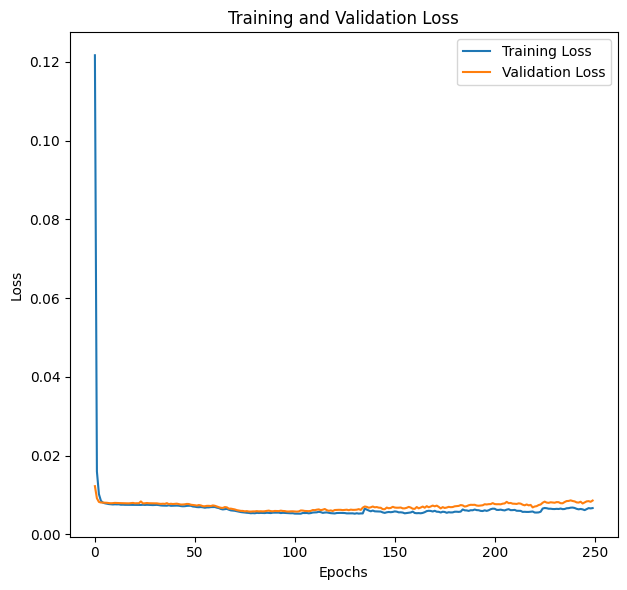

In [8]:
import matplotlib.pyplot as plt

# Extract training history from the history object
train_loss = history_linear.history['loss']
val_loss = history_linear.history['val_loss']
train_accuracy = history_linear.history.get('accuracy', [])
val_accuracy = history_linear.history.get('val_accuracy', [])

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot (if available)
if train_accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label="Training Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
#model.load_weights("D:/lab_work_25/AUG/ppg to ecg/best_kuramoto_mode2_sub5.h5")

20/20 [==============================] - 2s 74ms/step


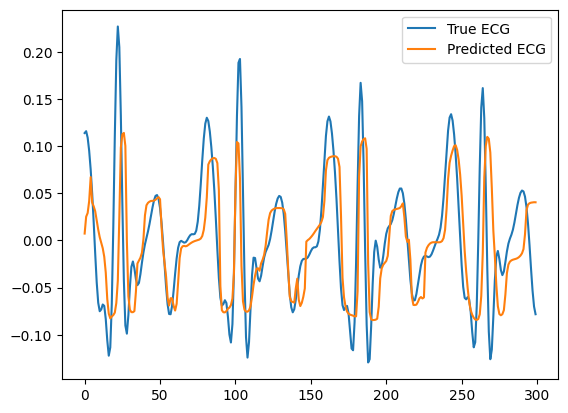

In [9]:
y_pred = model.predict(X_test, batch_size=1)
y_pred.shape
plt.plot(y_test[10,:,:], label='True ECG')
plt.plot(y_pred[10,:,:], label='Predicted ECG')
plt.legend()
plt.show()

10/10 [==============================] - 1s 98ms/step


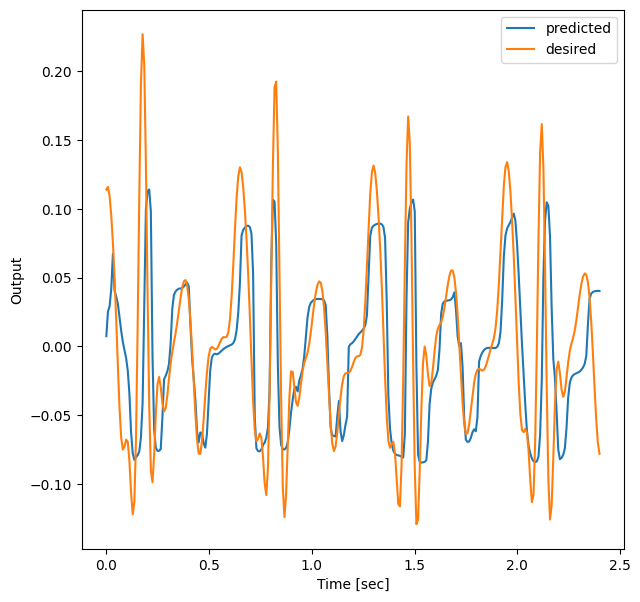

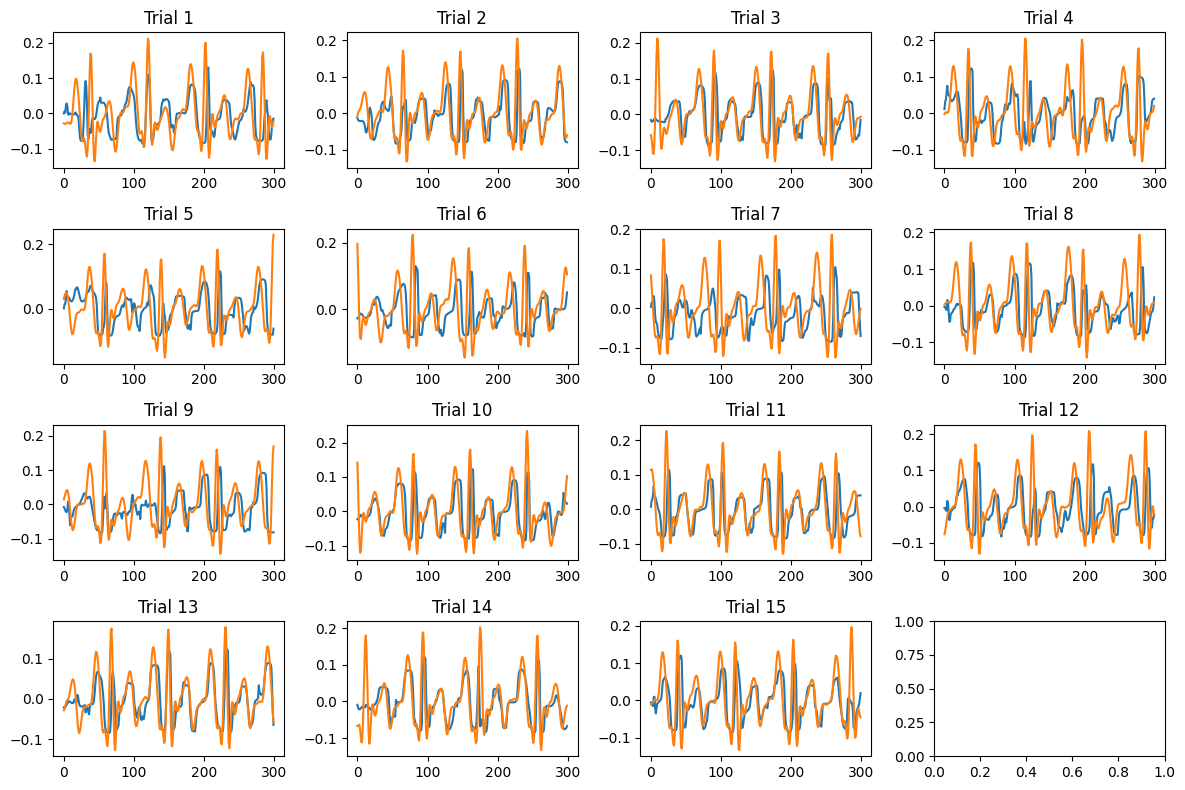

In [10]:
# ===========================
# Evaluation
# ===========================
'''out_train = model.predict(X_train, batch_size=2)
plt.plot(out_train[7], label="predicted")
plt.plot(y_train[7], label="desired")
plt.legend()
plt.show()'''

# Load best weights & test
#model.load_weights('D:/lab_work_25/AUG/ppg to ecg/best_kuramoto_mode2.h5')
out_test = model.predict(X_test, batch_size=2)

time_steps = np.linspace(0, 300 / 125, 300)
plt.figure(figsize=(7, 7))
plt.plot(time_steps, out_test[10], label="predicted")
plt.plot(time_steps, y_test[10], label="desired")
plt.xlabel("Time [sec]")
plt.ylabel("Output")
plt.legend()
plt.show()

# Multiple subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 8))
axs = axs.flatten()
for i in range(15):
    axs[i].plot(out_test[i])
    axs[i].plot(y_test[i])
    axs[i].set_title(f"Trial {i+1}")
plt.tight_layout()
plt.show()

In [11]:
print(out_test.shape)
print(y_test.shape)

(20, 300, 1)
(20, 300, 1)


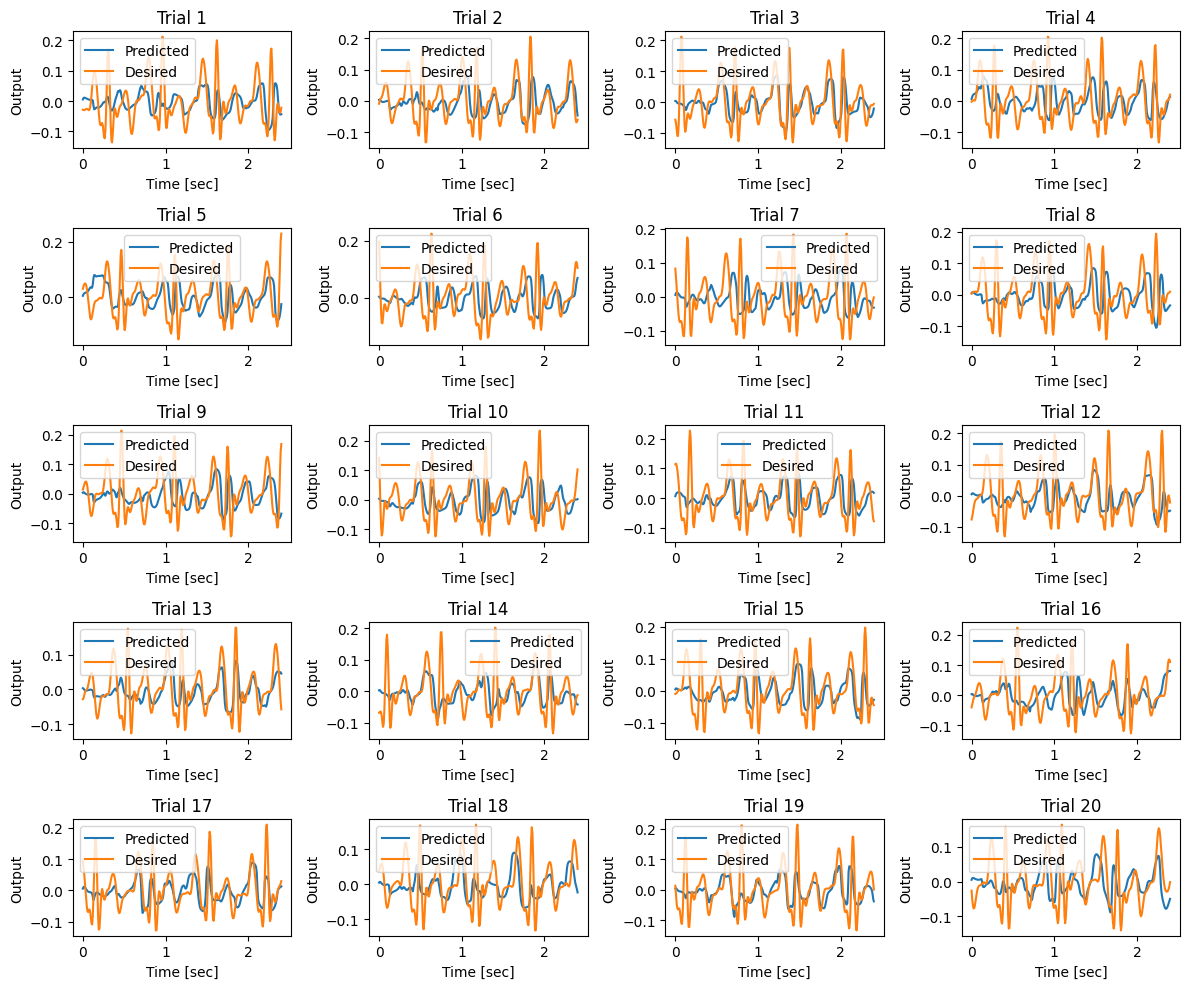

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming out_test and y_test are your data
# You can flatten them and plot in subplots
fig, axs = plt.subplots(5, 4, figsize=(12, 10))  # 5x4 grid for 20 trials
axs = axs.flatten()

# Loop through all 20 trials (since out_test and y_test have shape (20, 300, 1))
for i in range(20):
    axs[i].plot(np.linspace(0, 300 / 125, 300), out_test[i].flatten(), label="Predicted")
    axs[i].plot(np.linspace(0, 300 / 125, 300), y_test[i].flatten(), label="Desired")
    axs[i].set_title(f"Trial {i+1}")
    axs[i].set_xlabel("Time [sec]")
    axs[i].set_ylabel("Output")
    axs[i].legend()

plt.tight_layout()
plt.show()


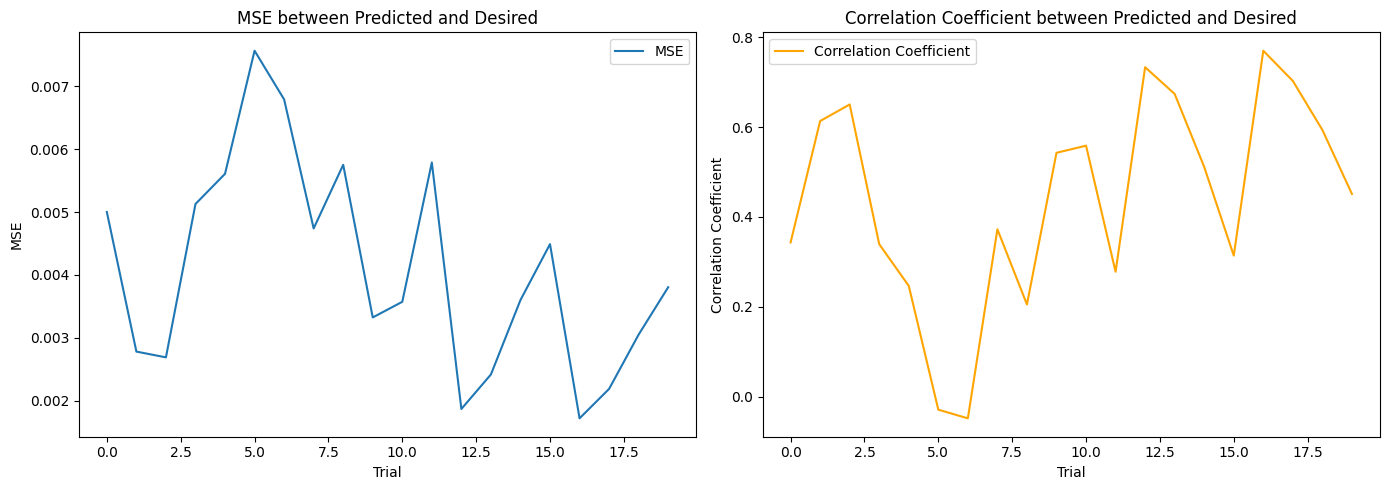

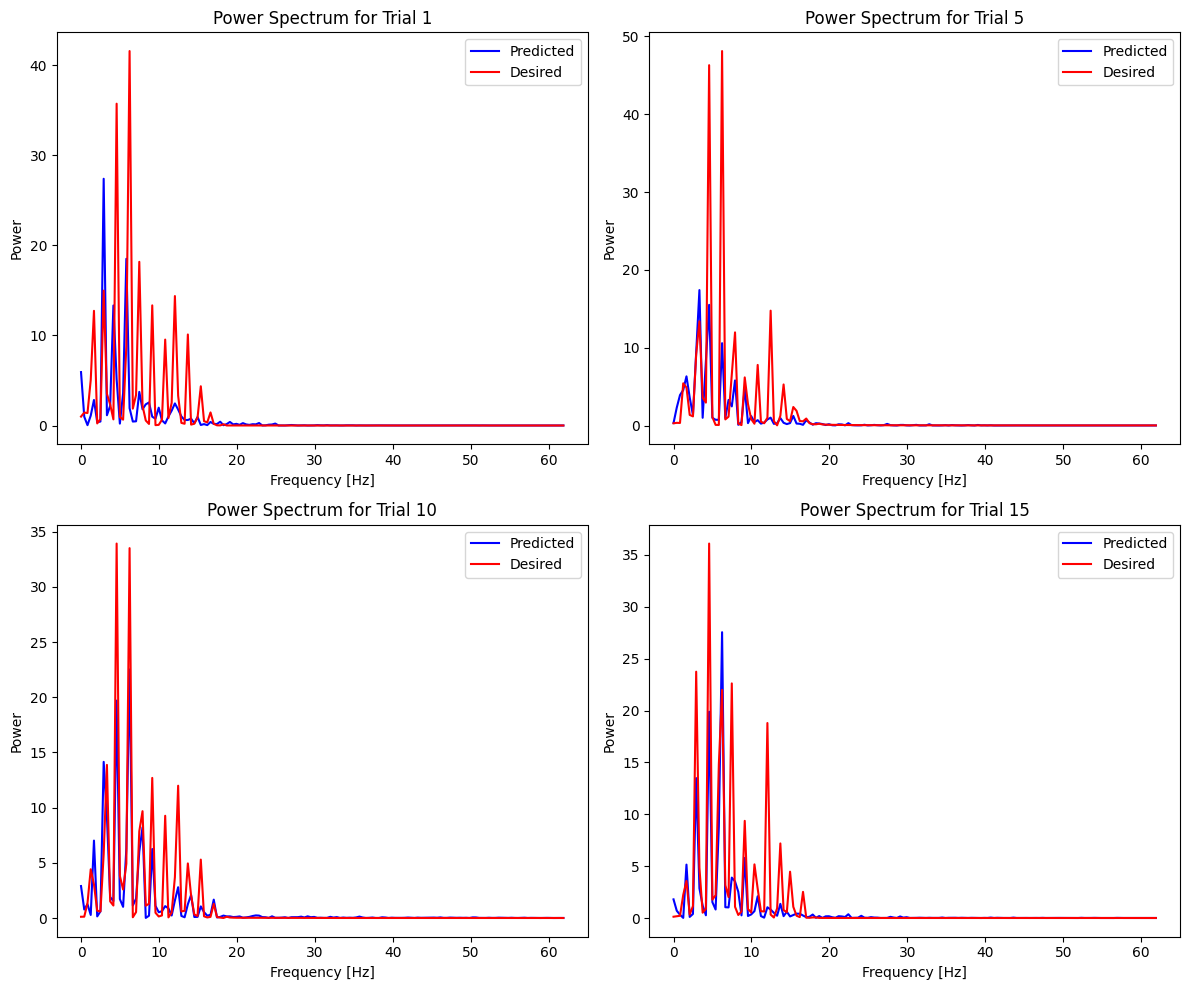

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr

# Calculate MSE, Correlation Coefficient, and Power Spectrum for each trial
mse_errors = []
correlation_coeffs = []
power_spectra = []

# Define the time step based on your data
time_steps = np.linspace(0, 300 / 125, 300)

for i in range(20):
    # Calculate MSE
    mse = np.mean((out_test[i].flatten() - y_test[i].flatten())**2)
    mse_errors.append(mse)
    
    # Calculate Pearson Correlation Coefficient
    corr_coef, _ = pearsonr(out_test[i].flatten(), y_test[i].flatten())
    correlation_coeffs.append(corr_coef)
    
    # Calculate Power Spectrum (FFT)
    N = len(time_steps)
    fft_out = fft(out_test[i].flatten())
    fft_y = fft(y_test[i].flatten())
    
    # Frequency bins
    freqs = fftfreq(N, (time_steps[1] - time_steps[0]))
    
    # Compute power spectrum (magnitude of the FFT squared)
    power_out = np.abs(fft_out)**2
    power_y = np.abs(fft_y)**2
    
    # Append to power_spectra
    power_spectra.append((freqs, power_out, power_y))

# Plot MSE and Correlation Coefficients
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(mse_errors, label="MSE")
axs[0].set_title("MSE between Predicted and Desired")
axs[0].set_xlabel("Trial")
axs[0].set_ylabel("MSE")
axs[0].legend()

axs[1].plot(correlation_coeffs, label="Correlation Coefficient", color='orange')
axs[1].set_title("Correlation Coefficient between Predicted and Desired")
axs[1].set_xlabel("Trial")
axs[1].set_ylabel("Correlation Coefficient")
axs[1].legend()

plt.tight_layout()
plt.show()

# Plot Power Spectrum for a few trials (example: trial 1, 5, 10, 15)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, ax in zip([0, 4, 9, 14], axs):  # Plots for trial 1, 5, 10, 15
    freqs, power_out, power_y = power_spectra[i]
    
    ax.plot(freqs[:len(freqs)//2], power_out[:len(freqs)//2], label="Predicted", color='blue')
    ax.plot(freqs[:len(freqs)//2], power_y[:len(freqs)//2], label="Desired", color='red')
    
    ax.set_title(f"Power Spectrum for Trial {i+1}")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Power")
    ax.legend()

plt.tight_layout()
plt.show()


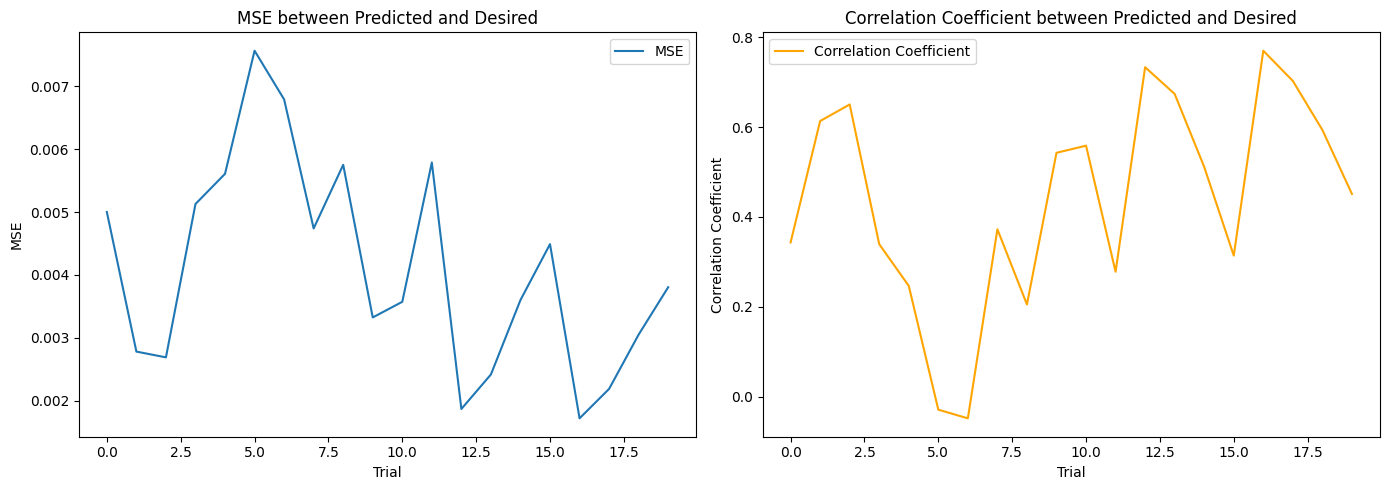

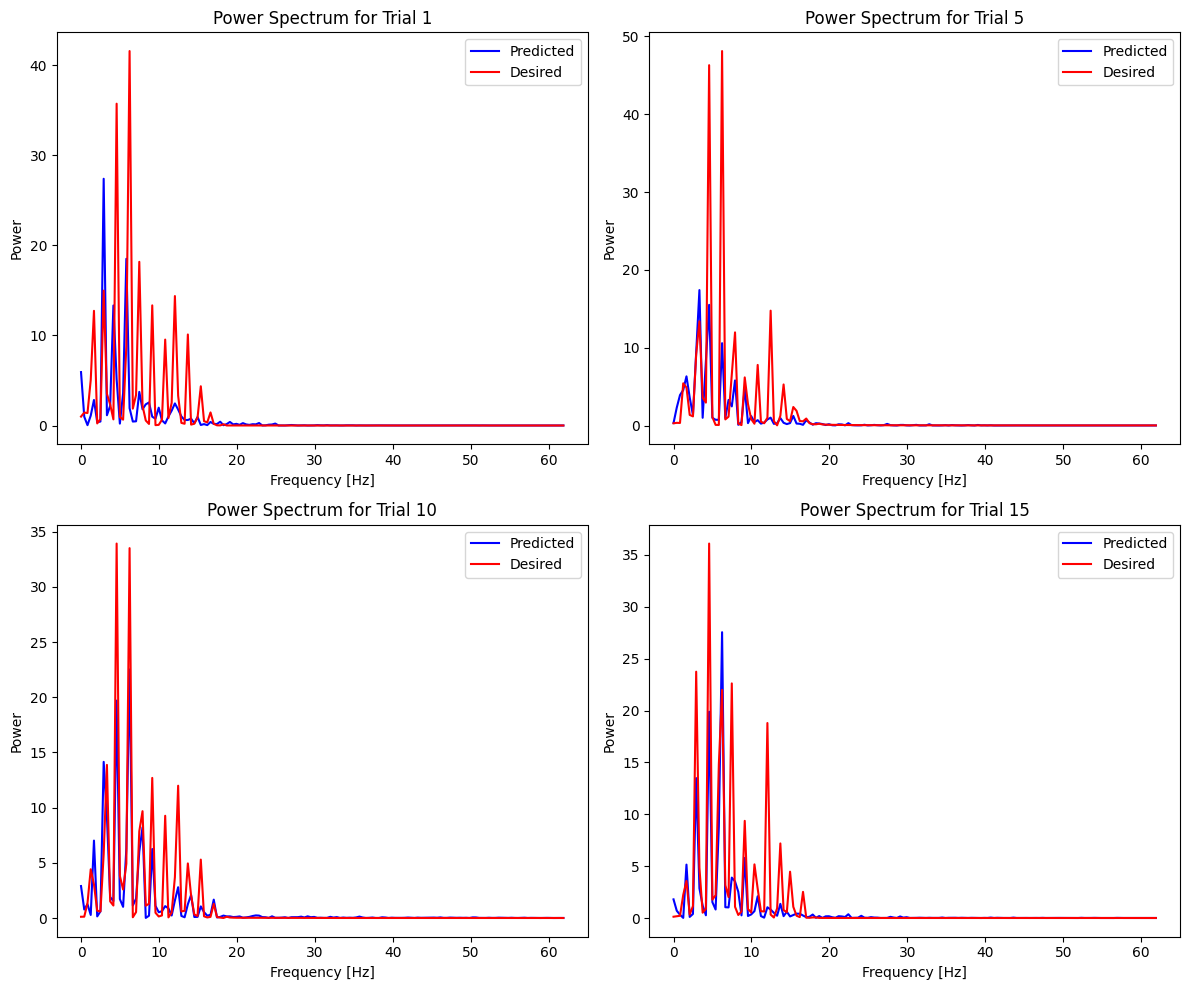

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr

# Calculate MSE, Correlation Coefficient, and Power Spectrum for each trial
mse_errors = []
correlation_coeffs = []
power_spectra = []

# Define the time step based on your data
time_steps = np.linspace(0, 300 / 125, 300)

for i in range(20):
    # Calculate MSE
    mse = np.mean((out_test[i].flatten() - y_test[i].flatten())**2)
    mse_errors.append(mse)
    
    # Calculate Pearson Correlation Coefficient
    corr_coef, _ = pearsonr(out_test[i].flatten(), y_test[i].flatten())
    correlation_coeffs.append(corr_coef)
    
    # Calculate Power Spectrum (FFT)
    N = len(time_steps)
    fft_out = fft(out_test[i].flatten())
    fft_y = fft(y_test[i].flatten())
    
    # Frequency bins
    freqs = fftfreq(N, (time_steps[1] - time_steps[0]))
    
    # Compute power spectrum (magnitude of the FFT squared)
    power_out = np.abs(fft_out)**2
    power_y = np.abs(fft_y)**2
    
    # Append to power_spectra
    power_spectra.append((freqs, power_out, power_y))

# Plot MSE and Correlation Coefficients
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(mse_errors, label="MSE")
axs[0].set_title("MSE between Predicted and Desired")
axs[0].set_xlabel("Trial")
axs[0].set_ylabel("MSE")
axs[0].legend()

axs[1].plot(correlation_coeffs, label="Correlation Coefficient", color='orange')
axs[1].set_title("Correlation Coefficient between Predicted and Desired")
axs[1].set_xlabel("Trial")
axs[1].set_ylabel("Correlation Coefficient")
axs[1].legend()

plt.tight_layout()
plt.show()

# Plot Power Spectrum for a few trials (example: trial 1, 5, 10, 15)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, ax in zip([0, 4, 9, 14], axs):  # Plots for trial 1, 5, 10, 15
    freqs, power_out, power_y = power_spectra[i]
    
    ax.plot(freqs[:len(freqs)//2], power_out[:len(freqs)//2], label="Predicted", color='blue')
    ax.plot(freqs[:len(freqs)//2], power_y[:len(freqs)//2], label="Desired", color='red')
    
    ax.set_title(f"Power Spectrum for Trial {i+1}")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Power")
    ax.legend()

plt.tight_layout()
plt.show()


=== Trial-wise Errors & Correlations ===
Trial 1: MSE=0.005001, MAE=0.049329, Corr=0.3433, PowerErr=0.000000
Trial 2: MSE=0.002781, MAE=0.036070, Corr=0.6137, PowerErr=0.000000
Trial 3: MSE=0.002690, MAE=0.036194, Corr=0.6506, PowerErr=0.000000
Trial 4: MSE=0.005128, MAE=0.049909, Corr=0.3394, PowerErr=0.000000
Trial 5: MSE=0.005608, MAE=0.055107, Corr=0.2465, PowerErr=0.000000
Trial 6: MSE=0.007565, MAE=0.061067, Corr=-0.0292, PowerErr=0.000000
Trial 7: MSE=0.006791, MAE=0.063026, Corr=-0.0485, PowerErr=0.000000
Trial 8: MSE=0.004739, MAE=0.047529, Corr=0.3726, PowerErr=0.000000
Trial 9: MSE=0.005751, MAE=0.053376, Corr=0.2052, PowerErr=0.000000
Trial 10: MSE=0.003324, MAE=0.037092, Corr=0.5430, PowerErr=0.000000
Trial 11: MSE=0.003573, MAE=0.039864, Corr=0.5588, PowerErr=0.000000
Trial 12: MSE=0.005788, MAE=0.052244, Corr=0.2780, PowerErr=0.000000
Trial 13: MSE=0.001869, MAE=0.028648, Corr=0.7336, PowerErr=0.000000
Trial 14: MSE=0.002418, MAE=0.030708, Corr=0.6741, PowerErr=0.000000


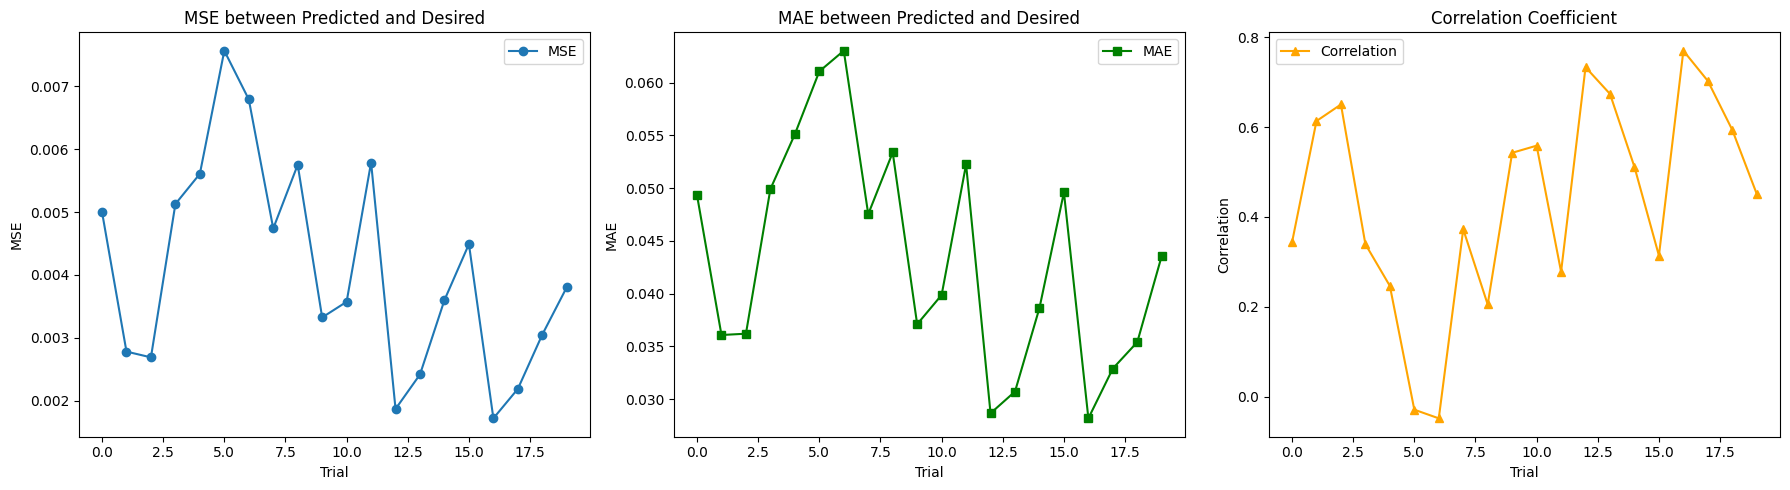

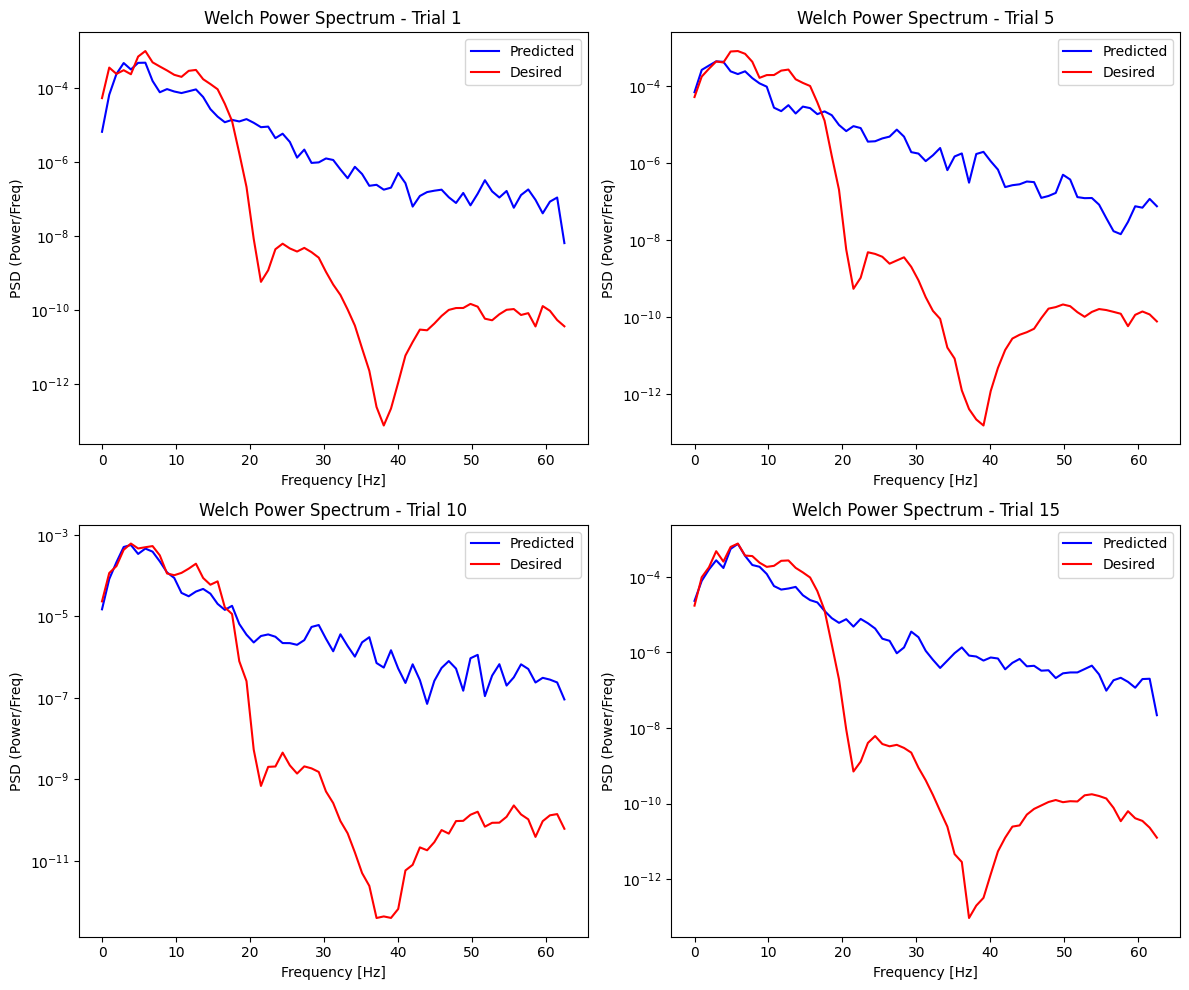

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import pearsonr

# Calculate MSE, MAE, Correlation Coefficient, and Power Spectrum for each trial
mse_errors = []
mae_errors = []
correlation_coeffs = []
power_spectra = []
power_errors = []  # power spectrum error (MSE between PSDs)

# Define the time step based on your data
fs = 125   # sampling frequency
time_steps = np.linspace(0, 300 / fs, 300)

for i in range(20):
    y_pred = out_test[i].flatten()
    y_true = y_test[i].flatten()
    
    # Calculate MSE
    mse = np.mean((y_pred - y_true) ** 2)
    mse_errors.append(mse)

    # Calculate MAE
    mae = np.mean(np.abs(y_pred - y_true))
    mae_errors.append(mae)
    
    # Calculate Pearson Correlation Coefficient
    corr_coef, _ = pearsonr(y_pred, y_true)
    correlation_coeffs.append(corr_coef)
    
    # Power Spectrum using Welch method
    freqs, power_out = welch(y_pred, fs=fs, nperseg=128)
    _, power_y = welch(y_true, fs=fs, nperseg=128)
    
    # Power spectrum error (MSE between PSDs)
    power_error = np.mean((power_out - power_y) ** 2)
    power_errors.append(power_error)
    
    # Append to power_spectra
    power_spectra.append((freqs, power_out, power_y))

# ==========================
# PRINT ALL VALUES
# ==========================
print("=== Trial-wise Errors & Correlations ===")
for i in range(20):
    print(f"Trial {i+1}: MSE={mse_errors[i]:.6f}, MAE={mae_errors[i]:.6f}, Corr={correlation_coeffs[i]:.4f}, PowerErr={power_errors[i]:.6f}")

# ==========================
# PLOTS
# ==========================

# Plot MSE, MAE, Correlation
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(mse_errors, label="MSE", marker='o')
axs[0].set_title("MSE between Predicted and Desired")
axs[0].set_xlabel("Trial")
axs[0].set_ylabel("MSE")
axs[0].legend()

axs[1].plot(mae_errors, label="MAE", marker='s', color='green')
axs[1].set_title("MAE between Predicted and Desired")
axs[1].set_xlabel("Trial")
axs[1].set_ylabel("MAE")
axs[1].legend()

axs[2].plot(correlation_coeffs, label="Correlation", marker='^', color='orange')
axs[2].set_title("Correlation Coefficient")
axs[2].set_xlabel("Trial")
axs[2].set_ylabel("Correlation")
axs[2].legend()

plt.tight_layout()
plt.show()

# Plot Power Spectrum for a few trials (example: trial 1, 5, 10, 15)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, ax in zip([0, 4, 9, 14], axs):  # Trials 1, 5, 10, 15
    freqs, power_out, power_y = power_spectra[i]
    
    ax.semilogy(freqs, power_out, label="Predicted", color='blue')
    ax.semilogy(freqs, power_y, label="Desired", color='red')
    
    ax.set_title(f"Welch Power Spectrum - Trial {i+1}")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("PSD (Power/Freq)")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import pearsonr

# Select the 18th sample (index 17 because of 0-based indexing)
y_true_18 = y_test[17].flatten()   # shape (300,)
y_pred_18 = out_test[17].flatten()   # shape (300,)

# Pearson correlation
corr_18, _ = pearsonr(y_true_18, y_pred_18)

print(f"Correlation coefficient for 18th sample: {corr_18:.4f}")


Correlation coefficient for 18th sample: 0.4318


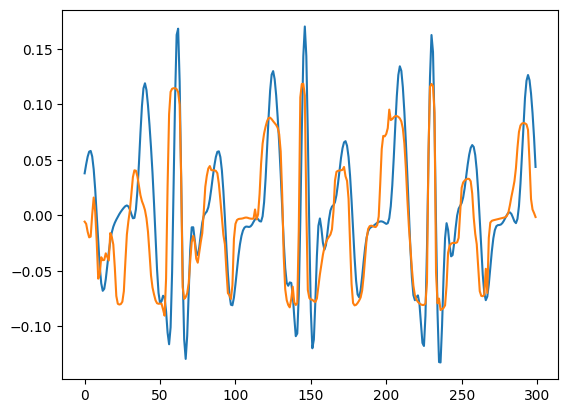

In [15]:
plt.plot(y_test[17])
plt.plot(out_test[17])